In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# # !pip install gymnasium
# !pip install stable-baselines3 gym-anytrading gym

In [3]:
# import gym
# import gym_anytrading

# from stable_baselines3 import A2C
# from stable_baselines3.common.vec_env import DummyVecEnv

2018-07-19 - 2018-07-26


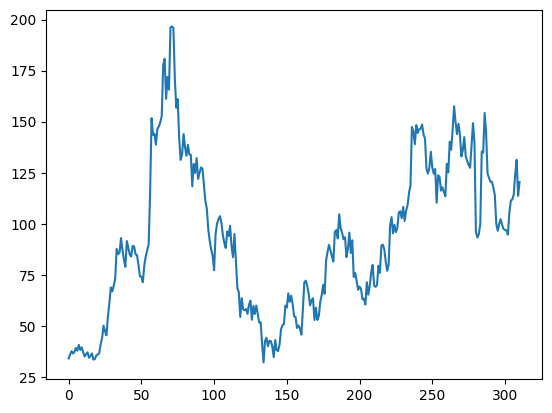

311
78


In [78]:
def generate_data():
    df = pd.read_csv("/kaggle/input/pdd-stocks/PDD_weekly.csv")
    Opentrain = []
    Hightrain = []
    Lowtrain = []
    Closetrain = []
    Volumetrain = []
    
    
    for index , row in df.iterrows():
        if index <= (len(df)-1)*0.8:
            Opentrain.append(row.iloc[2])
            Hightrain.append(row.iloc[4])
            Lowtrain.append(row.iloc[5])
            Closetrain.append(row.iloc[3])
            Volumetrain.append(row.iloc[1])
        if index == (len(df)-1):
            print(row.iloc[0])

    Opentrain=list(reversed(Opentrain))
    Hightrain=list(reversed(Hightrain))
    Lowtrain=list(reversed(Lowtrain))
    Closetrain=list(reversed(Closetrain))
    Volumetrain=list(reversed(Volumetrain))

    open_train = np.array(Opentrain)
    high_train = np.array(Hightrain)
    low_train = np.array(Lowtrain)
    close_train = np.array(Closetrain)
    volume_train = np.array(Volumetrain)
    

    train = np.column_stack((open_train,high_train,low_train,close_train,volume_train))


    Opentest = []
    Hightest = []
    Lowtest = []
    Closetest = []
    Volumetest = []

    for index , row in df.iterrows():
        if index > (len(df)-1)*0.8:
            Opentest.append(row.iloc[2])
            Hightest.append(row.iloc[4])
            Lowtest.append(row.iloc[5])
            Closetest.append(row.iloc[3])
            Volumetest.append(row.iloc[1])

    Opentest=list(reversed(Opentest))
    Hightest=list(reversed(Hightest))
    Lowtest=list(reversed(Lowtest))
    Closetest=list(reversed(Closetest))
    Volumetest=list(reversed(Volumetest))

    open_test = np.array(Opentest)
    high_test = np.array(Hightest)
    low_test = np.array(Lowtest)
    close_test = np.array(Closetest)
    volume_test = np.array(Volumetest)
    
    test = np.column_stack((open_test,high_test,low_test,close_test,volume_test))
    plot = plt.plot(Closetrain)
    plt.show(plot)

    
    return train, test
    
train, test = generate_data()

print(len(train))
print(len(test))



In [74]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import progressbar
import time
import math
import random
from itertools import groupby




class TradingEnv(gym.Env):
    def __init__(self, data, initial_balance = 100000):
        super(TradingEnv, self).__init__()
        self.initial_balance = initial_balance
        self.balance = 100000
        self.current_step = 0
        self.stock_amount = 0
        self.data = data
        self.state = (data[self.current_step])
        self.total = self.balance + (self.stock_amount*self.data[self.current_step][3])
        self.fee = 0.02
        
        self.action_space = spaces.Discrete(3) # buy-sell-hold
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(5,)) #open-high-low-close-volume
        self.balance_history = [100000]
        self.price_history = [self.data[0][3]]
        self.action_history = []
        self.asset_history = [self.total]


    
    def reset(self): # Đặt lại vị trí ban đầu
        self.balance = 100000
        self.current_step = 0
        self.balace_history = []
        self.price_history = []
        self.action_history = []
        return self._next_observation()


    def _next_observation(self):
        return self.data[self.current_step]


    def count_action(self):
        count = {}
        for i in self.action_history:
            if i not in count:
                count[i] = 0
            count[i] += 1
        return count


    def count_repeat(self,lst):
        return [(key, len(list(group))) for key, group in groupby(lst)]


    def step(self, action):
        self.price_history.append(self.data[self.current_step][3])
        repeat = self.count_repeat(self.action_history)
        # count = self.count_action()
        executed = action[0]
        amount = action[1]
        penalty = 1060
        mult = math.ceil(self.stock_amount*action[1])
        buy_map = {0: 0.38, 1 : 0.462, 2: 0.544, 3: 0.626, 4: 0.708, 5: 0.79} #percentage of current balance
        sell_map = {0: 0.07,1 : 0.228, 2: 0.386, 3: 0.544, 4: 0.742, 5: 0.86} #percentage of current stock amount
        if executed == 0:  # BUY
            mult = buy_map[amount]
            buy_cost = (self.balance * mult)
            buy_amount = buy_cost // self.data[self.current_step][3]
            total_cost = buy_amount * self.data[self.current_step][3] * (1 + self.fee)
            if total_cost <= self.balance:
                self.stock_amount += buy_amount
                self.balance -= total_cost
                trade_reward = 1.0
                if len(self.price_history)>1:
                    trade_reward = 1.0 if self.price_history[-1] < self.price_history[-2] else -1.0
            else:
                trade_reward = -1.5

            
            
            
        if executed == 1:  # SELL
            if self.stock_amount > 0:
                mult = sell_map[amount]
                sell_amount = max(1, min(math.floor(self.stock_amount * mult), self.stock_amount))  # Ensure at least 1 if possible
                if sell_amount > 0:
                    sell_value = sell_amount * self.data[self.current_step][3]
                    fee = sell_value * self.fee
                    net_proceeds = sell_value - fee
                    self.stock_amount -= sell_amount
                    self.balance += net_proceeds
                    trade_reward = 1.0  # Reward based on proceeds
                    if len(self.price_history)>1:
                        trade_reward = 1.0 if self.price_history[-1] > self.price_history[-2] else -1.0
                    # print(f"SELL: {sell_amount} stocks at {self.data[self.current_step][3]}, "
                    #       f"Net Proceeds: {net_proceeds}, Balance: {self.balance}, Stocks: {self.stock_amount}")
                else:
                    trade_reward = -1.0  # Penalty for zero sell amount (unlikely with max(1, ...))
            else:
                trade_reward = -1.5  # Penalty for no stock to sell


        elif executed == 2: 
            if self.stock_amount > 1 and len(self.price_history) > 1:
                if self.price_history[-1] < self.price_history[-2]:
                    trade_reward = 1.5
                # if repeat[-1][0] == 2 and repeat[-1][1] > 28:
                #     self.balance -= penaly
                else:
                    trade_reward = -1.0
            else:
                trade_reward= -1.0

        if self.balance > self.initial_balance:
            trade_reward = (self.balance - self.initial_balance)/1000


        self.balance_history.append(self.balance)
        self.price_history.append(self.data[self.current_step][3])
        if self.current_step < len(self.data) - 1:
            self.current_step += 1

        # status = False
        # if self.balance < 5000:
        #     status = True
        #     print("terminated as balance exceeded")
        status = False
        
        if self.total <1000:
            status = True
            print("terminated as total asset below standard")

        if self.balance < -5000:
            status = True

        if self.current_step >= (len(self.data)-1):
            print("terminated as epochs end")
            status = True
        else:
            status = False
        

        reward = ((self.balance - self.balance_history[-1]) / self.initial_balance) + trade_reward 

        return self._next_observation, reward, f"Action taken: {executed}", status



class TradingAgent():
    def __init__(self,
        env):
        self.env = env
        self.discount_factor = 0.95
        self.epsilon = 0.4
        self.Q_table = np.random.rand(len(self.env.data),3,6) #"""step - action - amount""" 
        self.lr = 0.01

        # self.penalty = 1.060   
        # self.penalty_time = 28

        self.current_step = 0
        self.current_position = 0
        self.training_error = []
        self.status = False

    

    def get_action(self,step):
        if np.random.random() < self.epsilon:
            return (random.randint(0, 2), random.randint(0, 5))  # Random action, amount
        else:
            action_idx, amount_idx = np.unravel_index(np.argmax(self.Q_table[step]), (3, 6))
            return (action_idx, amount_idx)




    def reset(self):
        self.discount_factor = 0.95
        self.epsilon = 0.4
        self.lr = 0.01
        self.status = False



    def get_max_q(self):
        max_ = -0.1
        for i in self.Q_table[self.env.current_step]:
            # print("current i:" ,i)
            # print("current max: ",max_)
            for j in list(i):
                # print("current j: ",j)
                if (j > max_).any():
                    max_ = j
        return max_
                

    
    def policy_evaluation(self, action, reward):
        if self.env.current_step == len(self.env.data) - 1:
            self.done = True
            return
        """Cập nhật giá trị Q dựa trên kinh nghiệm"""
        old_value = self.Q_table[self.env.current_step - 1 , action[0], action [1]] #"""giá trị Q cũ"""
        next_max = self.get_max_q() #"""Giá trị Q tiếp theo"""
        # print("next_max: ",next_max)
        new_value = old_value + self.lr * (reward + self.discount_factor * float(next_max) - old_value) #"""cập nhật giá trị Q"""
        # print("CURRENT ACTION: ",action)
        self.Q_table[self.env.current_step, action[0],action[1]] = new_value



    def decay_epsilon(self):
        self.epsilon = max(0.01, self.epsilon * 0.995) #"""decay epsilon qua mỗi epoch"""

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [85]:
env = TradingEnv(train)
agent = TradingAgent(env)

asset_train_history = []
total_eps = 2000
action_map = {0: "BUY", 1:"SELL", 2:"HOLD"}
for episode in range(total_eps):
    rewards = 0
    agent.reset()
    next_obs = env.reset()
    # print("current balance: ",env.balance)
    print("EPISODE: ", episode)
    while agent.status != True:
        action = agent.get_action(env.current_step)
        env.action_history.append(action[0])
        obs, reward, _ , d = env.step(action)
        agent.status = d
        # update the agent'
        rewards += reward
        agent.policy_evaluation(action, reward)



        # if env.balance < 0:
        #     done = True\	
    # print("action history: ",env.action_history)

    asset_train = env.balance + (env.stock_amount*env.data[env.current_step][3])
    agent.decay_epsilon()

    print(f"ASSET: {asset_train}, CASH: {env.balance}, STOCK: {env.stock_amount}")
    asset_train_history.append(asset_train)
    action_count = env.count_action()
    print(f"ACTION HISTORY: Buy-{action_count[0] if 0 in action_count else 0}, Sell-{action_count[1] if 1 in action_count else 0}, Hold-{action_count[2] if 2 in action_count else 0}")
    done = False
    print("------------------------------------------")
    
    # agent.reset()

# Q_maze = agent.Q_table()
# print(Q_maze)


EPISODE:  0
terminated as epochs end
ASSET: 104893.01424767995, CASH: 20080.044499999905, STOCK: 546.0
ACTION HISTORY: Buy-92, Sell-107, Hold-111
------------------------------------------
EPISODE:  1
terminated as epochs end
ASSET: 104893.01424767995, CASH: 68440.22930000008, STOCK: 1081.0
ACTION HISTORY: Buy-77, Sell-101, Hold-132
------------------------------------------
EPISODE:  2
terminated as epochs end
ASSET: 104893.01424767995, CASH: 96430.92819999967, STOCK: 1271.0
ACTION HISTORY: Buy-59, Sell-121, Hold-130
------------------------------------------
EPISODE:  3
terminated as epochs end
ASSET: 104893.01424767995, CASH: 26166.5227, STOCK: 1978.0
ACTION HISTORY: Buy-46, Sell-128, Hold-136
------------------------------------------
EPISODE:  4
terminated as epochs end
ASSET: 104893.01424767995, CASH: 45529.23539999999, STOCK: 633.0
ACTION HISTORY: Buy-44, Sell-136, Hold-130
------------------------------------------
EPISODE:  5
terminated as epochs end
ASSET: 104893.01424767995,

HIGHEST ACHIEVE|D ASSET IN TRAINING: 341619.1143999998


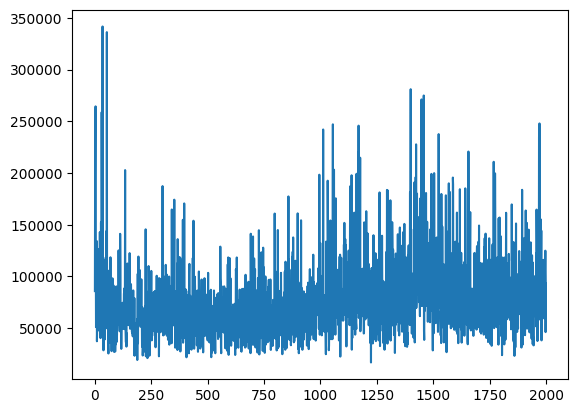

In [87]:
plt.plot(asset_train_history)
plt.show
print(f"HIGHEST ACHIEVE|D ASSET IN TRAINING: {max(asset_train_history)}")

In [ ]:
env.data = test
state = env.reset()
asset_history= []
# print("current balance: ",env.balance)
print("EPISODE: ", episode)
agent.status = False
while agent.status != True:
    print("------------------------------------------------------------------")
    action = agent.get_action(env.current_step)
    print("ACTION TAKEN: ",action_map[action[0]])
    obs, reward, _ , d = env.step(action)
    agent.status = d
    
    asset = env.balance + (env.stock_amount*env.data[env.current_step][3])
    print(f"ASSET: {asset}, CASH: {env.balance}, STOCK: {env.stock_amount}")
    # update the agent
    # agent.policy_evaluation(action, reward)
    # if env.balance < 0:
    #     done = True\	
# print("action history: ",env.action_history)
    asset_history.append(asset)

print("TRADE DONE")

In [ ]:
plt.plot(asset_history)
plt.show
print("HIGHEST ASSET AMOUNT ACHIEVED",max(asset_history))